In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# import random

# from matplotlib import pyplot as plt
# from statsmodels.stats.proportion import proportion_confint
# from sklearn.model_selection import train_test_split,KFold
# from sklearn.utils import check_random_state
# from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
# from skimage import exposure
# from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_probability as tfp
# from tensorflow.keras.models import Sequential, Model

import helper_functions as hlp
import function_read_data as rdat
import function_model_definition as md
import functions_gradcam as gc
import plot_function_gradcam as pgc

print("TF  Version",tf.__version__)

TF  Version 2.4.0


## Load Data

In [2]:
# Define the path + output path:
print(os.getcwd())
DIR = "/tf/notebooks/"
IMG_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
# IMG_DIR2 = "/tf/notebooks/kook/data-sets/stroke-lh/"
DATA_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
OUTPUT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/weights/"


/tf/notebooks/brdd/xAI_stroke_3d


In [3]:
# Define model
model_name = "3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_"

layer_connection = "globalAveragePooling"
last_activation = "sigmoid"

In [4]:
(X_train, X_valid, X_test), (y_train, y_valid, y_test), results = rdat.read_and_split_img_data(
    path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5', 
    path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv', 
    path_splits = '/tf/notebooks/brdd/xAI_stroke_3d/data/andrea_splits.csv', 
    split = 6, 
    check_print = True)

image shape in:  (439, 128, 128, 28, 1)
image min, max, mean, std:  -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0
tabular shape in:  (507, 16)
split file shape in:  (407, 3)
X tab out shape:  (407, 13)
Y mrs out shape:  (407,)
End shapes X (train, val, test):  (325, 128, 128, 28) (41, 128, 128, 28) (41, 128, 128, 28)
End shapes y (train, val, test):  (325,) (41,) (41,)


## Model

In [5]:
input_dim = np.expand_dims(X_train, axis = -1).shape[1:]
output_dim = 1

# call model
model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.summary()


Model: "cnn_3d_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 28, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 128, 28, 32)  896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 14, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 14, 32)    27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 32, 7, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 32, 7, 64)     55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 16, 16, 3, 64)     0   

In [6]:
model_3d.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

## Make Predictions

In [7]:
model_3d.load_weights("weights/" + model_name + "11" + ".h5")
# model_3d.evaluate(x=X_test, y=y_test)
# y_pred = model_3d.predict(X_test)

In [8]:
model_3d.evaluate(x=X_test, y=y_test)
y_pred = model_3d.predict(X_test)

2/2 [==============================] - 13s 5s/step - loss: 0.3709 - acc: 0.8504 - auc: 0.7446


## Asses Predictions

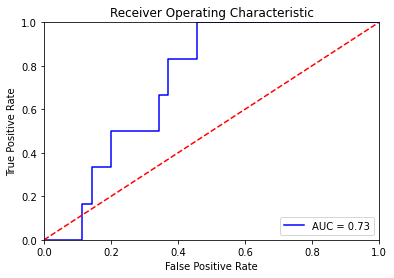

In [9]:
fpr, tpr, threshold = metrics.roc_curve(y_test, (y_pred))
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [10]:
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
print(threshold[index])

0.12495388


In [11]:
y_pred_label = (y_pred >= threshold[index]).squeeze()
np.mean(y_pred_label == y_test)

0.6097560975609756

In [12]:
1 - np.mean(y_test)

0.8536585365853658

In [13]:
print("spezifität: ", 1-fpr[index])
print("sensitivität: ", tpr[index])

spezifität:  0.5428571428571429
sensitivität:  1.0


In [14]:
import seaborn as sns

# results = pd.DataFrame(
#     {"p_idx": test_idx+1,
#      "p_id": p_id[test_idx],
#      "mrs": Y_mrs[test_idx],
#      "unfavorable": y_test,
#      "pred_prob": y_pred.squeeze()
#     }
# )
results["pred_prob"] = y_pred.squeeze()

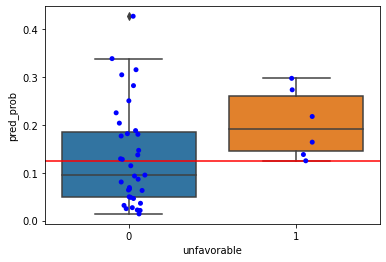

In [15]:
sns.boxplot(x = "unfavorable",
            y = "pred_prob",
            data = results)
sns.stripplot(x = "unfavorable",
              y = "pred_prob",
              color = 'blue',
              data = results)
plt.axhline(y = threshold[index], color = "red")

# GradCam

## GradCam Layer Iteration 

In [16]:
# # which_patients = [25] #16, 24
# which_patients = results[results.p_id == 460].index
# vis_layers = [i.name for i in model_3d.layers[1:-6]]
# # vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]
# pic_size = (128,128)

# for j in which_patients:
#     print("p_id: ", p_id[test_idx][j])
#     print("mrs: ", Y_mrs[test_idx][j])
#     print("pred: ", y_pred[j])
#     print("\n")

#     for vis_layer in vis_layers:
#         print("Layer: ", vis_layer)
#         heatmap, resized_img = gc.grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = vis_layer)

#         pgc.plot_gradcam(resized_img, heatmap,
#                 version = "overlay",
#                 mode = "avg")
#         pgc.plot_gradcam(resized_img, heatmap,
#                 version = "overlay",
#                 mode = "max")
        
    
#     layer_mode = "mean"
#     heatmap, resized_img = gc.multi_layers_grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layers = vis_layers, mode = layer_mode)
    
#     print(layer_mode, "over all Layers")
#     pgc.plot_gradcam(resized_img, heatmap,
#                 version = "overlay",
#                 mode = "avg")
#     pgc.plot_gradcam(resized_img, heatmap,
#                 version = "overlay",
#                 mode = "max")
#     print("Original")
#     pgc.plot_gradcam(resized_img, heatmap,
#                 version = "original",
#                 mode = "max")

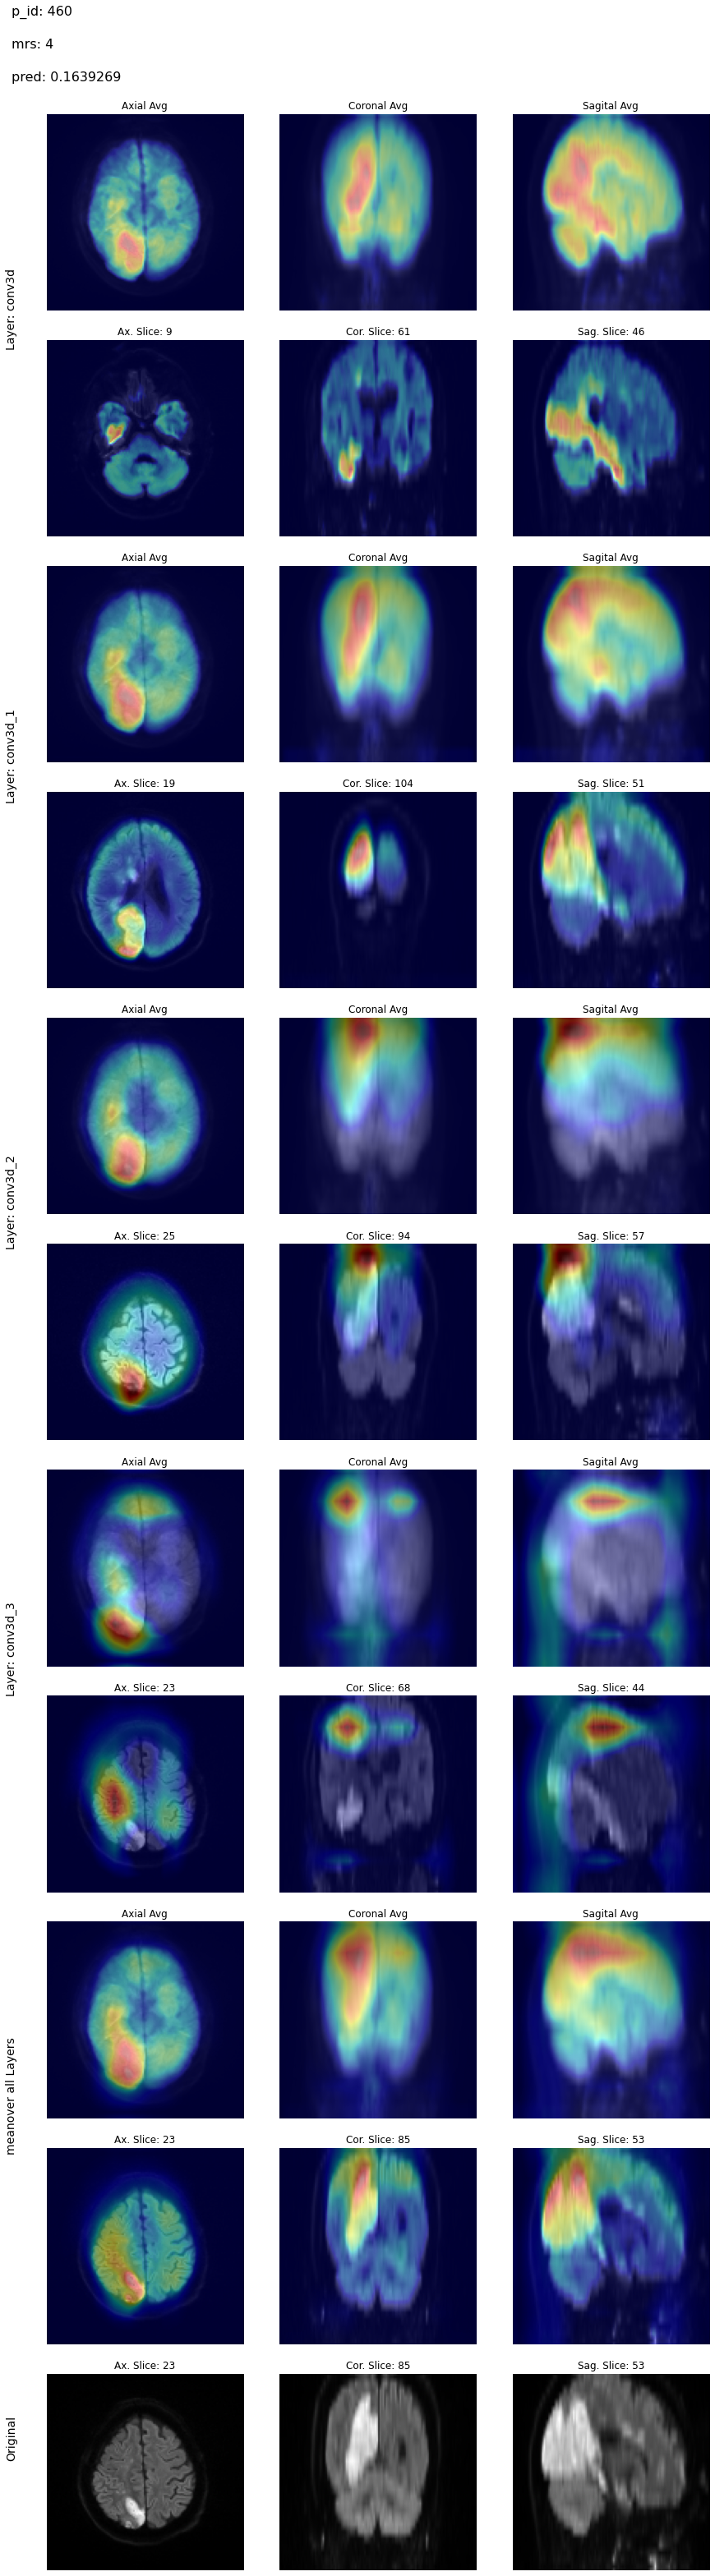

In [17]:
# import matplotlib.patches as patches

# which_patients = [25] #16, 24
pat_id = 460
which_patients = results[results.p_id == pat_id].index
vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

for j in which_patients:   
    plot_per_iter = 2
    plot_at_end = 1
    num_rows = len(vis_layers)*plot_per_iter + plot_per_iter + plot_at_end
    width = 15
    
    start_text = 0.12
    end_text = 0.88
    text_pos = np.flip(np.linspace(
        start_text+(plot_at_end/num_rows)+0.6/(num_rows-plot_at_end), 
        end_text-0.6/(num_rows-plot_at_end), 
        len(vis_layers)+1))
    
    fig = plt.figure(figsize = (width,num_rows*width/3))
    
    plt.gcf().text(0.1, end_text+3/num_rows/9, "p_id: " + str(round(results["p_id"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+2/num_rows/9, "mrs: " + str(round(results["mrs"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+1/num_rows/9, "pred: " + str(results["pred_prob"][j]), fontsize=16)

    for i, vis_layer in enumerate(vis_layers):
#         print("Layer: ", vis_layer)
        plt.gcf().text(0.1, text_pos[i], "Layer: " + vis_layer, 
                       horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    
        heatmap, resized_img = gc.grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = vis_layer)

        pgc.plot_gradcam(resized_img, heatmap,
                     version = "overlay",
                     mode = "avg",
                     add_plot = (i*2,num_rows),
                     show = False)
        pgc.plot_gradcam(resized_img, heatmap,
                     version = "overlay",
                     mode = "max",
                     add_plot = (i*2+1,num_rows),
                     show = False)
        
    
    layer_mode = "mean"
    heatmap, resized_img = gc.multi_layers_grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layers = vis_layers, mode = layer_mode)
    
#     print(layer_mode, "over all Layers")
    plt.gcf().text(0.1, text_pos[-1], layer_mode + "over all Layers", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "avg",
                add_plot = (num_rows-3,num_rows),
                show = False)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "max",
                add_plot = (num_rows-2,num_rows),
                show = False)
    
#     print("Original")
    plt.gcf().text(0.1, start_text+(plot_at_end/num_rows)/2, "Original", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "original",
                mode = "max",
                add_plot = (num_rows-1,num_rows),
                show = False)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    plt.savefig('pictures/p' + str(pat_id) + '_all_layers.png')


### Mean Over Multiple Layers

In [18]:
results.head()

p_idx   p_id  mrs  unfavorable  pred_prob
0    372  516.0  1.0            0   0.036066
1    284  376.0  2.0            0   0.048404
2    298  390.0  2.0            0   0.137240
3    203  286.0  0.0            0   0.188111
4    292  384.0  0.0            0   0.024814

In [19]:
j = results[results.p_id == 460].index[0]
print(j)
layer_mode = "mean"

25


['conv3d', 'conv3d_1', 'conv3d_2', 'conv3d_3']


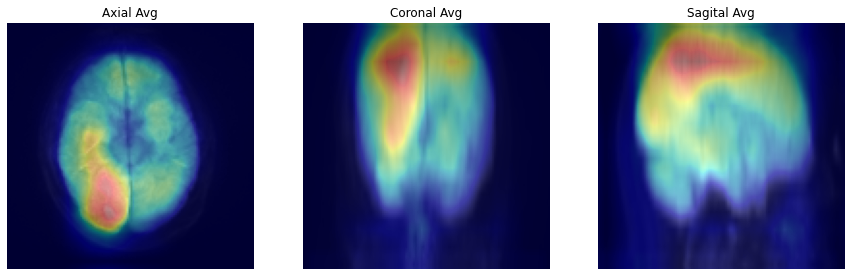

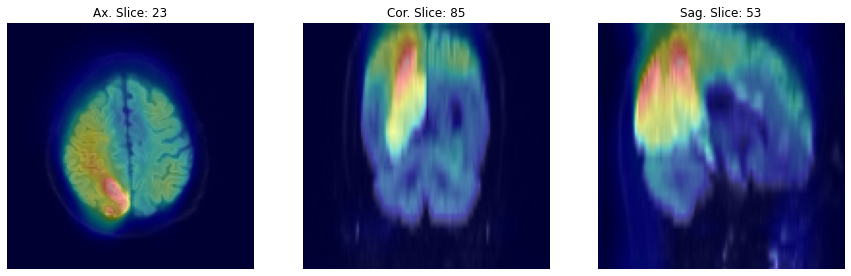

In [20]:
# conv layers only
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]
print(vis_layers)

heatmap, resized_img = gc.multi_layers_grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layers = vis_layers, mode = layer_mode)
    
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")

['conv3d', 'max_pooling3d', 'conv3d_1', 'max_pooling3d_1', 'conv3d_2', 'max_pooling3d_2', 'conv3d_3']


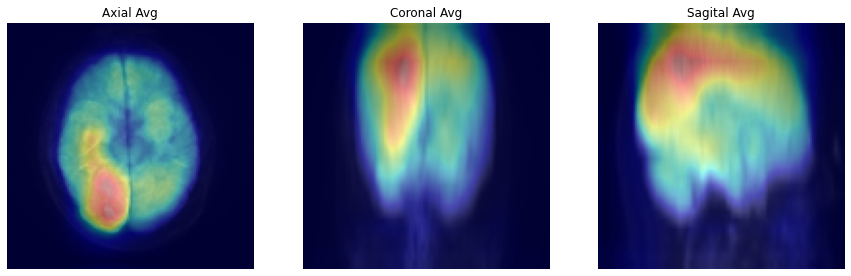

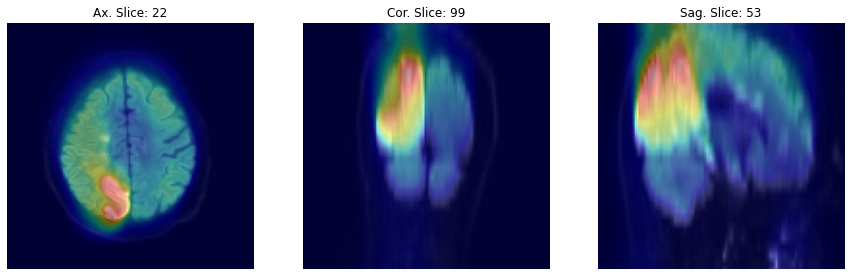

In [21]:
# all layers except last max pooling
vis_layers = [i.name for i in model_3d.layers[1:-7]]
print(vis_layers)

heatmap, resized_img = gc.multi_layers_grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layers = vis_layers, mode = layer_mode)
    
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")

conv3d_3


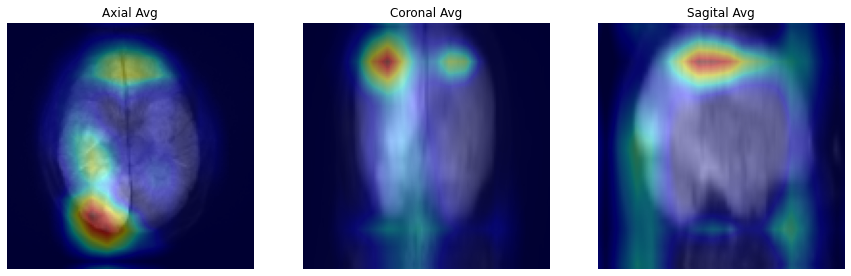

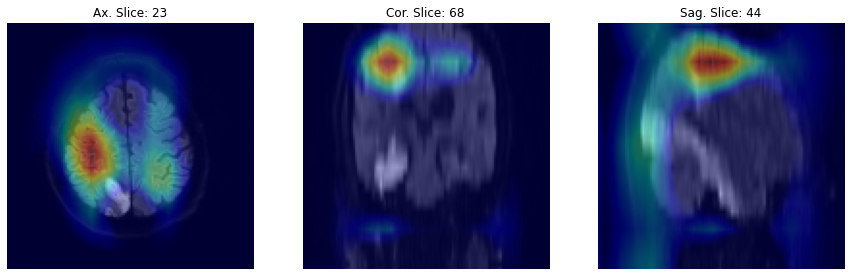

In [22]:
# last conv layer
vis_layers = 'conv3d_3'
print(vis_layers)

heatmap, resized_img = gc.grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = vis_layer)
    
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")

## Average GradCam

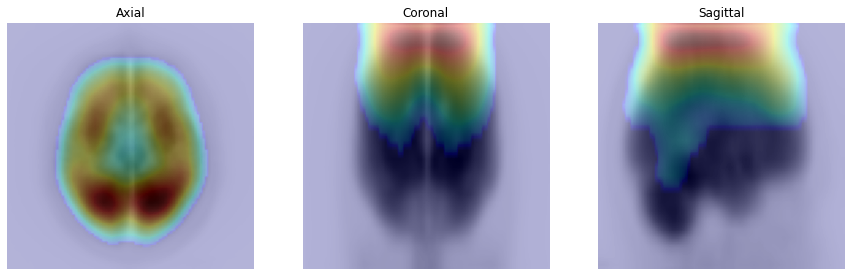

In [23]:
import skimage

visualization_layer_name = "conv3d_2"

h_l = []
i_l = []
for j in range(len(y_test)):
    
    heatmap, resized_img = gc.grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = visualization_layer_name)
    h_l.append(heatmap)
    i_l.append(resized_img)   

plt.figure(figsize = (15,45))
dsize = (91,91)
# axial average
plt.subplot(1,3,1)
plt.title('Axial')
axial = np.mean(np.array(h_l), (0,3))
th = np.max((np.mean(np.array(h_l), (0,3))))*0.2
axial[axial < th ] = 0
plt.imshow(skimage.transform.resize(np.negative(np.mean(np.array(i_l), (0,3))),output_shape=dsize), cmap='gray')
plt.imshow(skimage.transform.resize(axial,output_shape=dsize), alpha=0.3,cmap="jet")
plt.axis('off')
# coronal average
plt.subplot(1,3,2)
plt.title('Coronal')
coronal = np.mean(np.array(h_l), (0,1))
th = np.max((np.mean(np.array(h_l), (0,1))))*0.2
coronal[coronal < th ] = 0
plt.imshow(skimage.transform.resize(np.negative(np.rot90(np.mean(np.array(i_l), (0,1)))),output_shape=dsize), cmap='gray')
plt.imshow(skimage.transform.resize(np.rot90(coronal),output_shape=dsize), alpha=0.3,cmap="jet")
plt.axis('off')
# sagital average
plt.subplot(1,3,3)
plt.title('Sagittal')
sagital = np.mean(np.array(h_l), (0,2))
th = np.max((np.mean(np.array(h_l), (0,2))))*0.2
sagital[sagital < th ] = 0
plt.imshow(skimage.transform.resize(np.negative(np.fliplr(np.rot90(np.mean(np.array(i_l), (0,2))))), output_shape=dsize), cmap='gray')
plt.imshow(skimage.transform.resize(np.fliplr(np.rot90(sagital)),output_shape=dsize), alpha=0.3,cmap="jet")
plt.axis('off')

plt.show()

### Choose a patient

In [24]:
for i in model_3d.layers[1:-6]:
    print(i.name)

conv3d
max_pooling3d
conv3d_1
max_pooling3d_1
conv3d_2
max_pooling3d_2
conv3d_3
max_pooling3d_3


In [25]:
# axial
which_patients = [25] #16, 24
visualization_layer_name = "conv3d_3"

for j in which_patients:
    print("p_id: ", results["p_id"][j])
    print("mrs: ", results["mrs"][j])
    print("pred: ", results["pred_prob"][j])


p_id:  460.0
mrs:  4.0
pred:  0.1639269


In [26]:
heatmap, resized_img = gc.grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = visualization_layer_name)

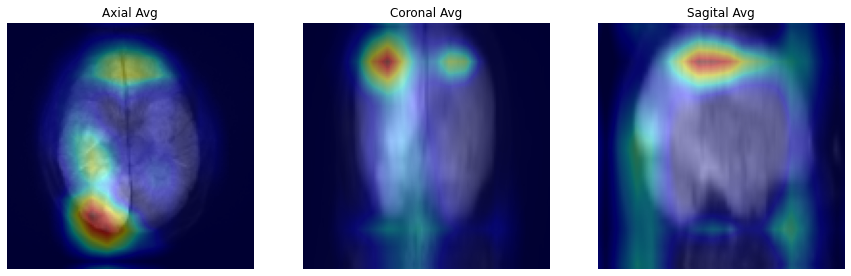

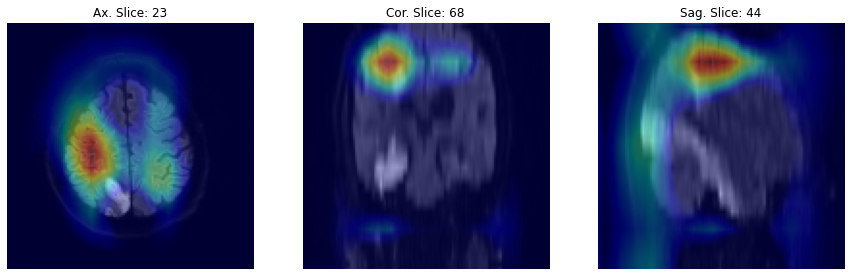

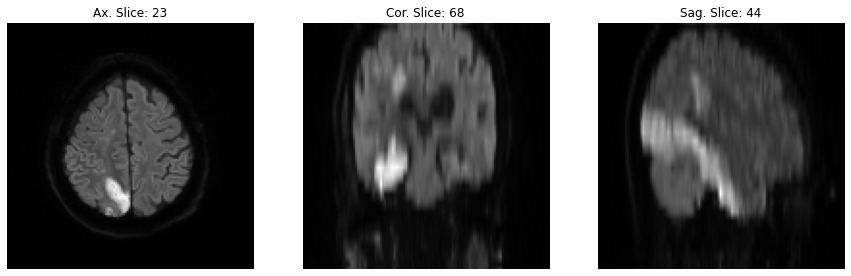

In [27]:
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

#### Plot multiple slices

p_id:  384.0
mrs:  0.0
pred:  0.024814144


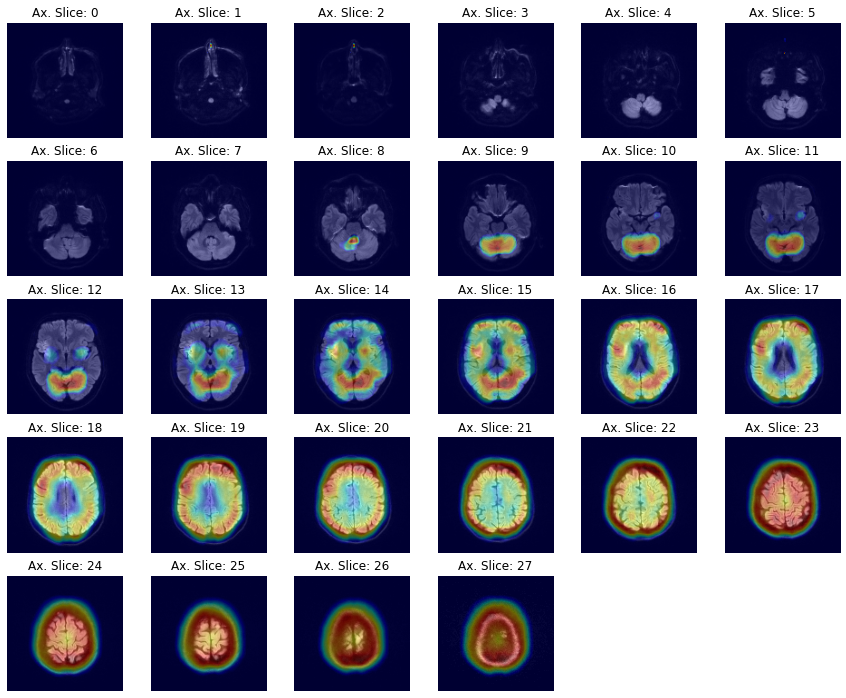

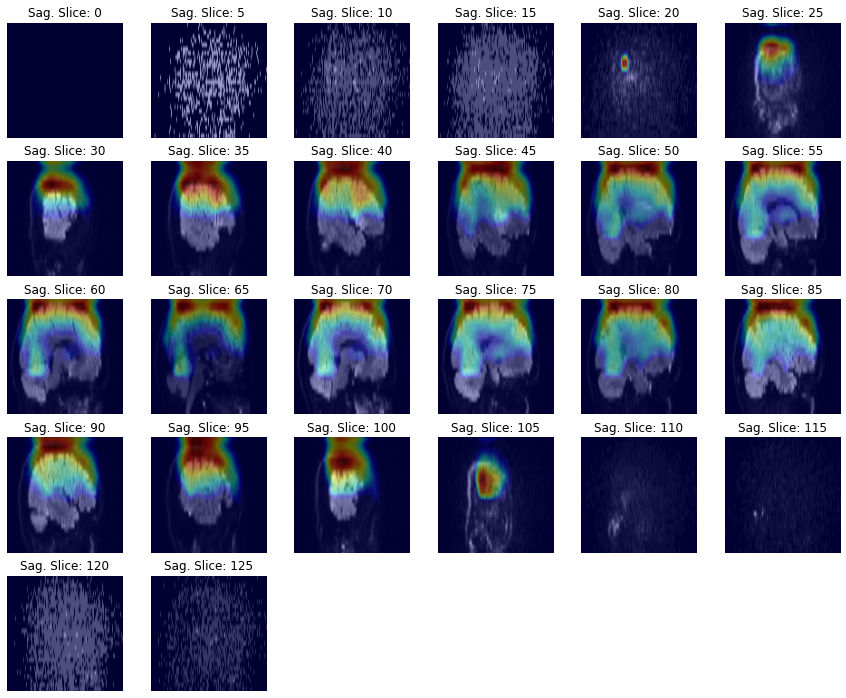

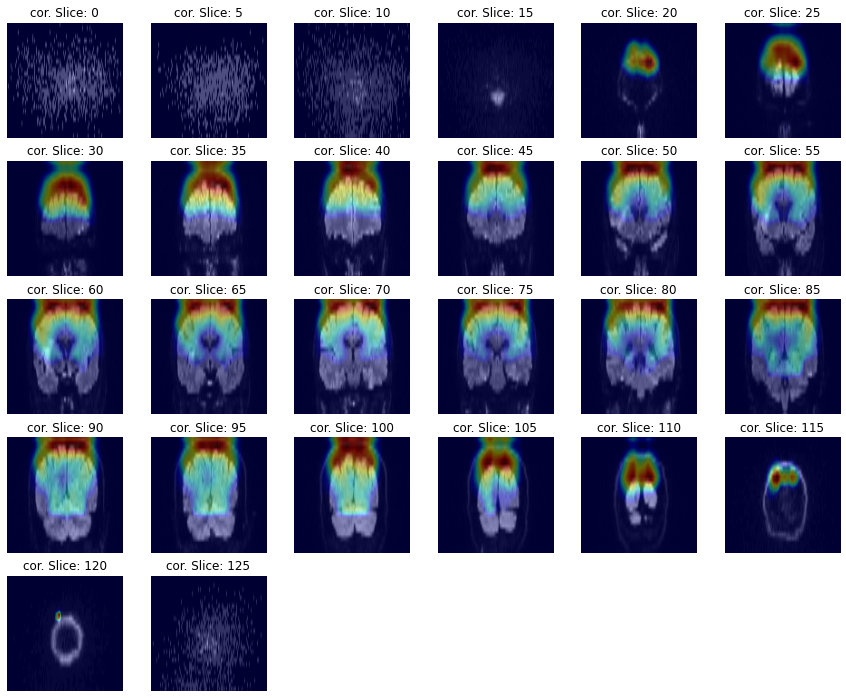

In [28]:
# axial
which_patients = [4]
visualization_layer_name = "conv3d_2"
pic_size = (128,128)

for j in which_patients:
    print("p_id: ", results["p_id"][j])
    print("mrs: ", results["mrs"][j])
    print("pred: ", results["pred_prob"][j])

for j in which_patients:
    heatmap, resized_img = gc.grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = visualization_layer_name)
    plt.figure(figsize=(15,25))
    
    for i, ax_slice in enumerate(range(0,28,1)):
        fig = plt.subplot(10,6, i+1)
        fig.imshow(resized_img[:,:,ax_slice ], cmap='gray')
        fig.imshow(heatmap[:,:,ax_slice], alpha=0.4,cmap="jet")
        fig.set_title("Ax. Slice: " + str(ax_slice))
        fig.axis('off')
        
    plt.show()
    
# sagital

for j in which_patients:
    heatmap, resized_img = gc.grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = visualization_layer_name)
    plt.figure(figsize=(15,25))
    
    for i, ax_slice in enumerate(range(0,128,5)):
        fig = plt.subplot(10,6, i+1)
        
        fig.imshow(skimage.transform.resize(np.fliplr(np.rot90(resized_img[:,ax_slice,: ])),output_shape=pic_size), cmap='gray')
        fig.imshow(skimage.transform.resize(np.fliplr(np.rot90(heatmap[:,ax_slice,:])),output_shape=pic_size), alpha=0.4,cmap="jet")
        
        fig.set_title("Sag. Slice: " + str(ax_slice))
        fig.axis('off')
        
    plt.show()
    
# coronal

for j in which_patients:
    heatmap, resized_img = gc.grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = visualization_layer_name)
    plt.figure(figsize=(15,25))
    
    for i, ax_slice in enumerate(range(0,128,5)):
        fig = plt.subplot(10,6, i+1)
        
        fig.imshow(skimage.transform.resize(np.rot90(resized_img[ax_slice,:,: ]),output_shape=pic_size), cmap='gray')
        fig.imshow(skimage.transform.resize(np.rot90(heatmap[ax_slice,:,:]),output_shape=pic_size), alpha=0.4,cmap="jet")
        
        fig.set_title("cor. Slice: " + str(ax_slice))
        fig.axis('off')
        
    plt.show()